## MIDS W207 Fall 2017 Final Project
# Decision Tree and Random Forest Models
Laura Williams, Kim Vignola, Cyprian Gascoigne  
Kaggle Project: San Francisco Crime Classification

## Introduction

In this notebook, we train boosted decision tree and random forest models [and possibly the a bagged tree model] on a dataset from the Kaggle competition called *San Francisco Crime Classification*, which is available here:  
https://www.kaggle.com/c/sf-crime

These models are intended to be run on a modified version of the dataset, so it is intended that this notebook follow implementation of our *Data Set Up* notebook.  Setting up our data included feature engineering, transformations, additional relevant data, and normalization, and is explained in more detail in the *Data Set Up* notebook.

The goal of our models is to predict the type of crime classification, based on time, date, and location features in the dataset from Kaggle, and other data we chose to add in the *Data Set Up* notebook. 

We evaluated our models using a log loss calculation on 20% of held back development data, for which we already had lables. We trained our models for submission to Kaggle on the entire set of training data, and submissed prediction probabilities on the test data to Kaggle for final scoring.

We found that the Random Forest classifier returned the best predictions for this dataset.

#### First import all packages used in this notebook:

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

#### Extract the modified dataset and load into numpy arrays

In [2]:
# Unzip data files into the "csv" subdirectory 

# **IMPORTANT**  This will overwrite existing files in the "csv" folder in your local repo
# with the most recent data files from the data.zip file

# Unzip 80% training data
unzip_training_data = zipfile.ZipFile("data_subset.zip", "r")
unzip_training_data.extractall()
unzip_training_data.close()

# Unzip development and training data
unzip_test_data = zipfile.ZipFile("testing.zip", "r")
unzip_test_data.extractall()
unzip_test_data.close()

# Unzip full set of training data for creating predictions to submit to Kaggle
unzip_all_data = zipfile.ZipFile("data.zip", "r")
unzip_all_data.extractall()
unzip_all_data.close()

In [3]:
# Load these csv files into numpy arrays for testing on development data
train_data = np.loadtxt('csv/train_data.csv', delimiter=",")
train_labels = np.loadtxt('csv/train_labels.csv', dtype=str, delimiter=",")
dev_data = np.loadtxt('csv/dev_data.csv', delimiter=",")
dev_labels = np.loadtxt('csv/dev_labels.csv', dtype=str, delimiter=",")

In [4]:
# Load these csv files into numpy arrays for creating predictions to submit to Kaggle
train_data_all = np.loadtxt('csv/train_data_all.csv', delimiter=",")
train_labels_all = np.loadtxt('csv/train_labels_all.csv', dtype=str, delimiter=",")
test_data_all = np.loadtxt('csv/test_data_all.csv', delimiter=",")

In [5]:
# print shapes to compare before and after csv conversion
print("train_data shape is", train_data.shape)
print("train_labels shape is", train_labels.shape)
print("dev_data shape is", dev_data.shape)
print("dev_labels shape is", dev_labels.shape)

train_data shape is (702439, 16)
train_labels shape is (702439,)
dev_data shape is (175610, 16)
dev_labels shape is (175610,)


In [6]:
print("train_data_all shape is", train_data_all.shape)
print("train_labels_all shape is", train_labels_all.shape)
print("test_data_all shape is", test_data_all.shape)

train_data_all shape is (878049, 16)
train_labels_all shape is (878049,)
test_data_all shape is (884262, 16)


## Random Forest Model

We first ran a random forest model with the baseline dataset (with no feature engineering other than making all features numeric.  The returned a log loss score on the dev data of 2.58505, and a Kaggle score of 2.58897.


Because the Random Forest Classifier returned the best log loss scores with default parameters, we chose this as our final model and invested time in tuning hyperparameters for this model.

Our experiments on an interim dataset with 58 features returned these optimal parameters:
n_estimators = 150  
max_features = 0.40  
max_depth = 16  

We subsequently narrowed our feature set, in particular after learning that binarization did not work well with random forests for this feature set.  We performed the same experiments on this smaller feature set and also evaluated overfitting for this feature set.  Our results are as follows:

max_depth: Best score on development data was max_depth=13, but overfitting increased over max_depth=9.  So our optimal max_depth to avoid overfitting is 9.  
max_features: Best score on development data was 0.30. Overfitting did not start until increasing the max_features above 0.30, so this is a good optimal value for max_features.  
n-estimators: Overfitting appeared to get worse with n=200, so we stuck with n=150



In [7]:
# Set up functions for training random forest and finding optimal hyperparameters

def TrainRF(data, labels, test_data, n, depth, features):
    """This function takes as input training data and labels, testing data,
    and can accept different values of hyperparameters, including:
    n (the number of random decision trees to create),
    max_depth (the depth of the tree), and 
    max_features (the subset of features the model randomly selects).
    
    This function trains a random forest model and returns the model and predicted probabilities.
    """
    RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
    RF.fit(data, labels)
    pp_test = RF.predict_proba(test_data)
    pp_train = RF.predict_proba(train_data)
    return RF, pp_test, pp_train

def find_max_depth(data, labels, dev_data, dev_labels, n, depth_values, features):
    """Find optimal value of max_depth in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    scores_dev = []
    scores_train = []
    for depth in depth_values:      
        RF, pp_dev, pp_train = TrainRF(data, labels, dev_data, n, depth, features)
        logloss_dev = metrics.log_loss(dev_labels, pp_dev)
        scores_dev.append(logloss_dev)
        logloss_train = metrics.log_loss(train_labels, pp_train)
        scores_train.append(logloss_train)
    return scores_dev, scores_train
        
def find_max_features(data, labels, dev_data, dev_labels, n, depth, num_features):
    """Find optimal value of max_features in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    scores_dev = []
    scores_train = []
    for f in num_features:      
        RF, pp_dev, pp_train = TrainRF(data, labels, dev_data, n, depth, f)
        logloss_dev = metrics.log_loss(dev_labels, pp_dev)
        scores_dev.append(logloss_dev)
        logloss_train = metrics.log_loss(train_labels, pp_train)
        scores_train.append(logloss_train)
    return scores_dev, scores_train


def find_n(data, labels, dev_data, dev_labels, n_values, depth, features):
    """Find optimal value of n in a random forest model.  
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.
    """
    scores_dev = []
    scores_train = []
    for n in n_values:      
        RF, pp_dev, pp_train = TrainRF(data, labels, dev_data, n, depth, features)
        logloss_dev = metrics.log_loss(dev_labels, pp_dev)
        scores_dev.append(logloss_dev)
        logloss_train = metrics.log_loss(train_labels, pp_train)
        scores_train.append(logloss_train)
    return scores_dev, scores_train

### Tuning hyperparameters
First we experimented with changing one hyperparameter at a time, leaving the remaining parameters at a value with minimal computational cost. This allowed us to quickly cycle through a large range of values for each hyperparameter to more easily target fine-tuning.

In random forests, the same parameters can return slightly different results when run multiple times because the classifer returns a randomly slightly different model every time.  For this reason, we ran each experiment multiple times and plotted the results.

Then we fine-tuned smaller ranges of values with higher computational cost, resulting at an optimal set of hyperparameters on which to train our final model.

#### Maximum depth of the decision tree (max_depth)

We experimented with different ranges of max_depth parameters while keeping the n_estimators and max_features small to speed up processing.

**IMPORTANT NOTE:**

The first set of parameter testing in each section was run using a previous version of the functions, and a previous version of the dataset.  They took quite a while to run and they are NOT meant to be re-run, but rather to show the hyperparameter testing we did in the middle of our project with an interim data set.

With a data set with 58 features, and the number of estimators and maximum number of features set to the default (n=10 and max_features = "sqrt"), we found that the optimal max_depth is usually 16 with a log loss score on the development data of about 2.422 through 2.438, though there is overlap with max_depth values of 15 through 18.

In [114]:
# Set up variables
n = 10
features="sqrt"
depth_values = [1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19]

# Run multiple iterations and record all scores
iterations = 10
all_depths = np.zeros((iterations, (len(depth_values))))
all_scores = np.zeros((iterations, (len(depth_values))))

for i in range(iterations):
    scores = find_max_depth(train_data, train_labels, dev_data, dev_labels, n, depth_values, features)
    all_depths[i] = depth_values
    all_scores[i] = scores

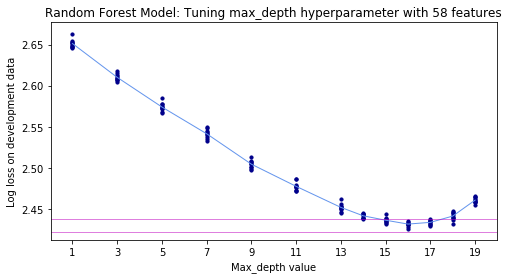

In [158]:
# Set up data for the plot
avg_score_per_depth = np.mean(all_scores, axis=0)

# Plot max_depth results
plt.figure(figsize=(8,4))
x = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
plt.xticks(x)
plt.xlabel("Max_depth value")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning max_depth hyperparameter with 58 features")
plt.plot(depth_values, avg_score_per_depth, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_depths, all_scores, c = "darkblue", s=10)
plt.axhline(y=2.422, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.438, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Depth.png")


Hyperparameters in random forests are sensitive to changes in feature number and type.

After deciding on a close-to-final feature set, we re-optimized hyperparameters.  This time we also collected predictions on both training data and development data to look for overfitting.  

The feature set on which this hyperparameter tuning is run includes a total of 16 features:  
month_year  
d_police  
hour  
day  
X and Y  
7 features representing spatal rotation  
3 added features representing weather  

This feature set used for hyperparameter testing contains a few fewer features than the full set of non-binarized features we created in the Data Set Up notebook. The feature set was reduced in the interest of saving time when tuning hyperparameters.  The features not included in final hyperparameter testing are those that showed the lowest importance from the random forest model (as reported in the Data Set Up notebook).  They are:  
seasons  
holidays  
first_days  
PdDistrict  
month  
year  
dayparts  
DayOfWeek  

In [8]:
# Set up variables
n = 10
features="sqrt"
depth_values = [5, 7, 9, 11, 13, 15, 16]

# Run multiple iterations and record all scores
iterations = 10
all_depths = np.zeros((iterations, (len(depth_values))))
all_scores_dev = np.zeros((iterations, (len(depth_values))))
all_scores_train = np.zeros((iterations, (len(depth_values))))

for i in range(iterations):
    scores_dev, scores_train = find_max_depth(train_data, train_labels, 
                                              dev_data, dev_labels, 
                                              n, depth_values, features)
    all_depths[i] = depth_values
    all_scores_dev[i] = scores_dev
    all_scores_train[i] = scores_train

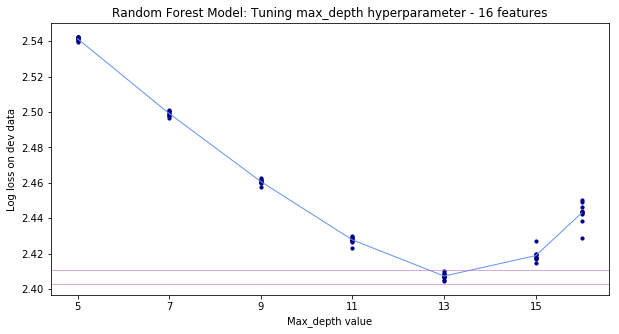

In [17]:
# Plot results

# Set up data for the plot
avg_score_per_depth = np.mean(all_scores_dev, axis=0)

# Plot max_depth results
plt.figure(figsize=(10,5))
x = [5, 7, 9, 11, 13, 15, 17]  
plt.xticks(x)
plt.xlabel("Max_depth value")
plt.ylabel("Log loss on dev data")
plt.title("Random Forest Model: Tuning max_depth hyperparameter - 16 features")
plt.plot(depth_values, avg_score_per_depth, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_depths, all_scores_dev, c = "darkblue", s=10)
# Cutoff lines for best scores with previous feature set
# plt.axhline(y=2.422, linewidth=0.5, color = 'mediumorchid')
# plt.axhline(y=2.438, linewidth=0.5, color = 'mediumorchid')
# Cutoff lines for best scores with this feature set
plt.axhline(y=2.403, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.411, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Depth_16_features.png")


When tuning hyperparameters on development data, it is really easy to to overfit to the development data.  So for each hyperparameter, we made predictions on both the train data and development data. Then we plotted the ratio of the log loss on the train data predictions vs. the log loss on on the development data predictions for each value of max_depth. 

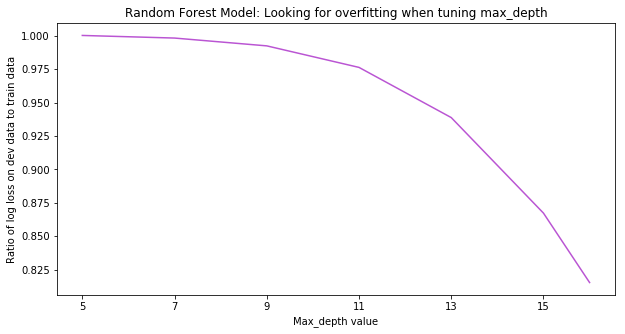

In [49]:
# Plot looking at overfitting for max_depth

# Set up data for the plot
avg_score_per_depth_dev = np.mean(all_scores_dev, axis=0)
avg_score_per_depth_train = np.mean(all_scores_train, axis=0)
ratios = avg_score_per_depth_train/avg_score_per_depth_dev

# Plot max_depth overfitting results
plt.figure(figsize=(10,5))
x = [5, 7, 9, 11, 13, 15, 17]  
plt.xticks(x)
plt.xlabel("Max_depth value")
plt.ylabel("Ratio of log loss on dev data to train data")
plt.title("Random Forest Model: Looking for overfitting when tuning max_depth")
plt.plot(depth_values, ratios, c="mediumorchid")
plt.show()
# plt.savefig("Images/Max_Depth_overfitting.png")


#### Maximum number of features in the model (max_features)

We experimented with different subset sizes of features that the random forest classifier randomly selects from the total feature set.  Common values include the square root and log base 2 of the total number of features.  Float values for this parameter will select the percentage of the total features (i.e., a float of 0.10 will select 10% of the features), and the *None* value will use all of the features.

**IMPORTANT NOTE:**

The first set of parameter testing in each section was run using a previous version of the functions, and a previous version of the dataset.  They took quite awhile to run and they are NOT meant to be re-run, but rather to show the hyperparameter testing we did in the middle of our project with an interim data set.

With a dataset of 58 features, with the number of estimators and maximum depth set to low values to minimize testing time (n=10 and max_depth = 5), we found that the optimal number of maximum features with these parameters is about 23 features, which is about 40% of the total feature set, a max_features value of 0.40.  With the non-optimal max_depth, this returned slightly higher log loss values of 2.530 - 2.542.

In [172]:
# Set up variables
n = 10
depth = 5
num_features = [0.05, 'sqrt', 0.10, 'log2', 0.15, 0.20, 0.25, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, None]
num_features_for_plotting = [0.05*train_data.shape[1],
                             np.sqrt(train_data.shape[1]), 
                             0.10*train_data.shape[1],                              
                             np.log2(train_data.shape[1]),
                             0.15*train_data.shape[1],
                             0.20*train_data.shape[1], 
                             0.25*train_data.shape[1],
                             0.30*train_data.shape[1],
                             0.40*train_data.shape[1],
                             0.50*train_data.shape[1],
                             0.60*train_data.shape[1],
                             0.70*train_data.shape[1],
                             0.80*train_data.shape[1],
                             0.90*train_data.shape[1],
                             train_data.shape[1]
                            ]

# Run multiple iterations
iterations = 10
all_num_features = np.zeros((iterations, (len(num_features))), dtype='object')
all_scores_features = np.zeros((iterations, (len(num_features))))

for i in range(iterations):
    scores = find_max_features(train_data, train_labels, dev_data, dev_labels, n, depth, num_features)
    all_num_features[i] = num_features_for_plotting
    all_scores_features[i] = scores

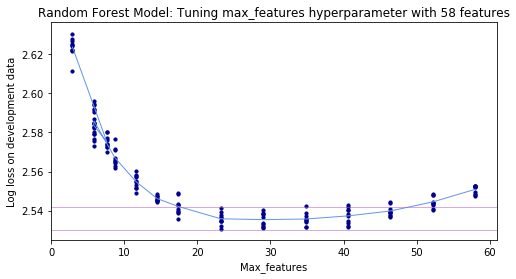

In [181]:
# Set up data for the plot
avg_score_per_num_features = np.mean(all_scores_features, axis=0)

# Plot max_features results
plt.figure(figsize=(8,4))
plt.xlabel("Max_features")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning max_features hyperparameter with 58 features")
plt.plot(num_features_for_plotting, avg_score_per_num_features, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_num_features, all_scores_features, c = "darkblue", s=10)
plt.axhline(y=2.530, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.542, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Features.png")

We then re-tested this parameter with the smaller, almost-final feature set detailed above in the section on max_depth.

There was not as much variability with max_features in this feature set. 

In [18]:
# Set up variables
n = 10
depth = 3
num_features = ['sqrt', 'log2', 0.20, 0.30, 0.40, 0.50, 0.60, 0.80, None]
num_features_for_plotting = [np.sqrt(train_data.shape[1]),                             
                             np.log2(train_data.shape[1]),
                             0.20*train_data.shape[1], 
                             0.30*train_data.shape[1],
                             0.40*train_data.shape[1],
                             0.50*train_data.shape[1],
                             0.60*train_data.shape[1],
                             0.80*train_data.shape[1],
                             train_data.shape[1]
                            ]

# Run multiple iterations
iterations = 10
all_num_features = np.zeros((iterations, (len(num_features))), dtype='object')
all_scores_dev_features = np.zeros((iterations, (len(num_features))))
all_scores_train_features = np.zeros((iterations, (len(num_features))))

for i in range(iterations):
    scores_dev, scores_train = find_max_features(train_data, train_labels, 
                                                 dev_data, dev_labels, 
                                                 n, depth, num_features)
    all_num_features[i] = num_features_for_plotting
    all_scores_dev_features[i] = scores_dev
    all_scores_train_features[i] = scores_train

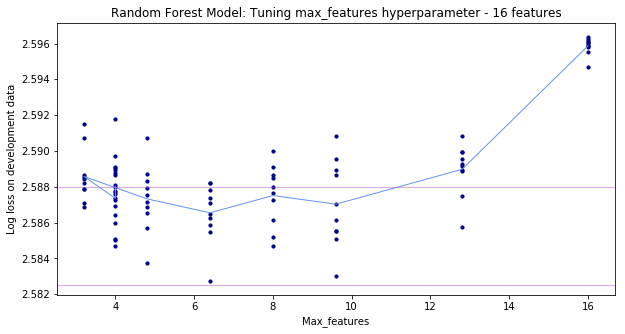

In [31]:
# Set up data for the plot
avg_score_per_num_features = np.mean(all_scores_dev_features, axis=0)

# Plot max_features results
plt.figure(figsize=(10,5))
plt.xlabel("Max_features")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning max_features hyperparameter - 16 features")
plt.plot(num_features_for_plotting, avg_score_per_num_features, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_num_features, all_scores_dev_features, c = "darkblue", s=10)
# Cutoffs for this plot
plt.axhline(y=2.5825, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.5880, linewidth=0.5, color = 'mediumorchid')
# Cutoffs from previous plot
# plt.axhline(y=2.530, linewidth=0.5, color = 'mediumorchid')
# plt.axhline(y=2.542, linewidth=0.5, color = 'mediumorchid')
plt.show()
# plt.savefig("Images/Max_Features_16_features.png")

We also tested our max_features hyperparameter for overfitting.

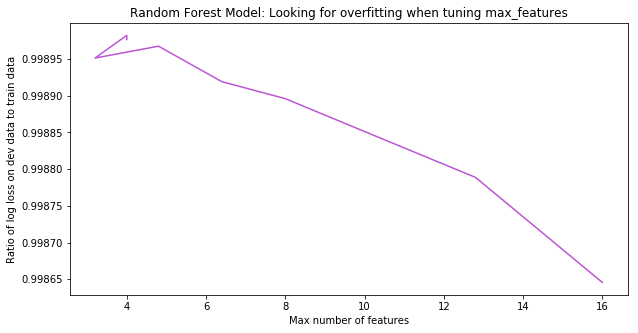

In [55]:
# Plot looking at overfitting for max_features

# Set up data for the plot
avg_score_per_features_dev = np.mean(all_scores_dev_features, axis=0)
avg_score_per_features_train = np.mean(all_scores_train_features, axis=0)
ratios_features = avg_score_per_features_dev/avg_score_per_features_train


# Plot max_features overfitting results
plt.figure(figsize=(10,5))
plt.xlabel("Max number of features")
plt.ylabel("Ratio of log loss on dev data to train data")
plt.title("Random Forest Model: Looking for overfitting when tuning max_features")
plt.plot(num_features_for_plotting, ratios_features, c="mediumorchid")
plt.show()
# plt.savefig("Images/Max_Features_overfitting.png")


#### Maximum number of random models (n_estimators)

We experimented with different values for the number of models the random forest classifier creates.

This hyperparameter exacts the most computational cost, so we first tried it out with very small values of the other hyperparameters (max_depth=3 and a feature subset of 10%)

Often random forest models are said to do much better with larger values of n_estimators, but we found that with the 58 feature data set and a these two other parameters, that we did not get dramatically better results above n = 150. We redid the experiment to look more closely at smaller values of n, and arrived at an optimal value for n_estimators of [add here].

In [191]:
# NOTE: With the default max_depth of None and n_jobs = -1 (using all cores), higher values of n crashed my laptop
# Apparently this is common with random forests
# The fix: limit max_depth and limit n_jobs to 1 core (n_jobs=1 is the default)  
# It takes a bit longer but doesn't crash in the middle of processing --Laura

# Set up variables
n_values = [10, 25, 50, 75, 100, 150, 200, 300, 400, 500, 750, 1000]
depth = 3
features = 0.10

# Run multiple iterations
iterations = 6
all_n_values = np.zeros((iterations, (len(n_values))))
all_scores_n_values = np.zeros((iterations, (len(n_values))))

for i in range(iterations):
    scores_dev, scores_train = find_n(train_data, train_labels, dev_data, dev_labels, n_values, depth, features)
    all_n_values[i] = n_values
    all_scores_n_values[i] = scores

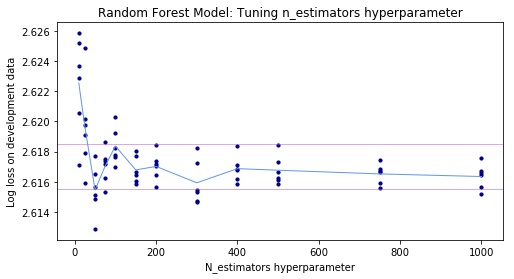

In [201]:
# Set up data for the plot
avg_score_per_n_value = np.mean(all_scores_n_values, axis=0)

# Set up plot
plt.figure(figsize=(8,4))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning n_estimators hyperparameter")
plt.plot(n_values, avg_score_per_n_value, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values, all_scores_n_values, c = "darkblue", s=10)
plt.axhline(y=2.6155, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.6185, linewidth=0.5, color = 'mediumorchid')
plt.show()
#plt.savefig("Images/Optimal_N_58_features.png")

In [207]:
# Set up variables to look at smaller values of n
n_values = [10, 25, 50, 75, 100, 150, 200]
depth = 3
features = 0.10

# Run multiple iterations
iterations = 10
all_n_values_small = np.zeros((iterations, (len(n_values))))
all_scores_n_values_small = np.zeros((iterations, (len(n_values))))

for i in range(iterations):
    scores = find_n(train_data, train_labels, dev_data, dev_labels, n_values, depth, features)
    all_n_values_small[i] = n_values
    all_scores_n_values_small[i] = scores

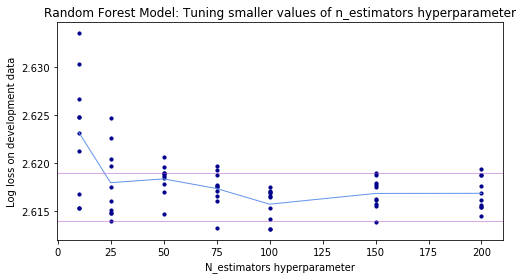

In [208]:
# Set up data for the plot
avg_score_per_n_value_small = np.mean(all_scores_n_values_small, axis=0)

# Set up plot
plt.figure(figsize=(8,4))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning smaller values of n_estimators hyperparameter")
plt.plot(n_values, avg_score_per_n_value_small, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n_values_small, all_scores_n_values_small, c = "darkblue", s=10)
plt.axhline(y=2.614, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.619, linewidth=0.5, color = 'mediumorchid')
plt.show()
#plt.savefig("Images/Optimal_N_Small_58Features.png")

We then re-tested this parameter with the smaller, almost-final feature set detailed above in the section on max_depth.



In [32]:
# Set up variables to look at smaller values of n
n_values = [50, 75, 100, 150, 200]
depth = 3
features = 0.10

# Run multiple iterations
iterations = 10
all_n = np.zeros((iterations, (len(n_values))))
all_scores_dev_n = np.zeros((iterations, (len(n_values))))
all_scores_train_n = np.zeros((iterations, (len(n_values))))

for i in range(iterations):
    scores_dev, scores_train = find_n(train_data, train_labels, dev_data, dev_labels, n_values, depth, features)
    all_n[i] = n_values
    all_scores_dev_n[i] = scores_dev
    all_scores_train_n[i] = scores_train

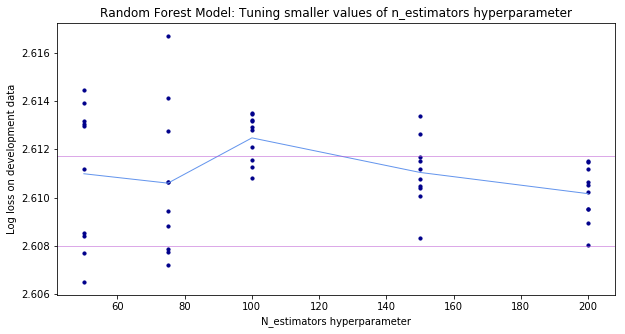

In [38]:
# Set up data for the plot
avg_score_per_n = np.mean(all_scores_dev_n, axis=0)

# Set up plot
plt.figure(figsize=(10,5))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Log loss on development data")
plt.title("Random Forest Model: Tuning smaller values of n_estimators hyperparameter")
plt.plot(n_values, avg_score_per_n, c="cornflowerblue", linewidth=1.0)
plt.scatter(all_n, all_scores_dev_n, c = "darkblue", s=10)
# Cutoff lines for current plot
plt.axhline(y=2.6117, linewidth=0.5, color = 'mediumorchid')
plt.axhline(y=2.608, linewidth=0.5, color = 'mediumorchid')
# Cutoff lines for previous plot 
# plt.axhline(y=2.614, linewidth=0.5, color = 'mediumorchid')
# plt.axhline(y=2.619, linewidth=0.5, color = 'mediumorchid')
plt.show()
#plt.savefig("Images/Optimal_N_Small_58Features.png")

We also looked at overfitting for the n_estimators up through n=200

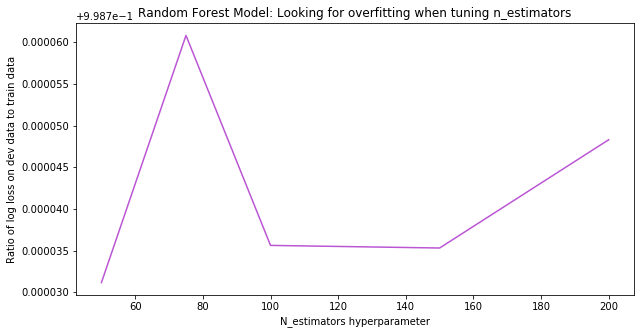

In [63]:
# Plot looking at overfitting for n_estimators

# Set up data for the plot
avg_score_per_n_dev = np.mean(all_scores_dev_n, axis=0)
avg_score_per_n_train = np.mean(all_scores_train_n, axis=0)
ratios_n = avg_score_per_n_dev/avg_score_per_n_train


# Plot max_features overfitting results
plt.figure(figsize=(10,5))
plt.xlabel("N_estimators hyperparameter")
plt.ylabel("Ratio of log loss on dev data to train data")
plt.title("Random Forest Model: Looking for overfitting when tuning n_estimators")
plt.plot(n_values, ratios_n, c="mediumorchid")
plt.show()
# plt.savefig("Images/n_estimator_overfitting.png")

#### Combine optimal hyperparameters

The model below combines the current feature set with the optimal hyperparameters for this feature set identified above.

We're looking for the combination to return equal or better log losses to the best values in any single type of hyperparameter testing above, which is, for the 16-feature set above were between 2.403 and 2.411


In [57]:
# Set up variables
n = 150
depth = 9
features = 0.30


RF = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
RF.fit(train_data, train_labels)
pp_dev = RF.predict_proba(dev_data)
logloss_dev = metrics.log_loss(dev_labels, pp_dev)
# Also fit the model back onto the training data to test for overfitting
pp_train = RF.predict_proba(train_data)
logloss_train = metrics.log_loss(train_labels, pp_train)

print("Log loss score on dev data is", logloss_dev)
print("Log loss score on train data is", logloss_train)

Log loss score on dev data is 2.45396761562
Log loss score on train data is 2.43568613187


In [58]:
print("Log loss ratio of dev data predictions to train data predictions is", logloss_dev/logloss_train)

Log loss ratio of dev data predictions to train data predictions is 1.00750568126


We submitted this model to Kaggle and got a score from Kaggle of 2.45854.  This Kaggle score better matches our dev data scores from interim experiments, telling us that our hyperparameter tuning on later models did a good job of eliminating overfitting.  We used a larger feature set with better overall predictive value with these optimal parameters to get a better final Kaggle score.

### Final model for Kaggle submission
After experimenting with all hyperparameters above using 80% of the training data and testing on 20% held back development data, we train a model on the current training set using the best parameters, and create predictions on the test set to submit to Kaggle.


In [60]:
# Train model with optimal hyperparameters on the full set of training data
# Make predictions on the test data
n = 150
depth = 9
features = 0.30
RF, pp_final, _ = TrainRF(train_data_all, train_labels_all, test_data_all, n, depth, features)

## Boosted Decision Tree
We wanted to try AdaBoost with the Decision Tree Classifier because sometimes this combination does better than the Random Forest classifier.  We tested this model with the dataset that had 58 features. We found that this classidifer did not do better than the Random Forest classifer but it got pretty close.

First we set up some functions for testing the hyperparameters in AdaBoost and the single Decision Tree classifier, because these are somewhat different than the Random Forest Classifier.

In [36]:
# Set up functions for boosted trees and finding optimal hyperparameters

def BoostedTree(data, labels, test_data, learn=1.0, n=10, depth=1):
    """This function takes in training data and labels, testing data,
    and can accept different values of n (number of estimators), 
    max_depth of the decision tree
    and can also accept different values of learning rate for the booster
    
    It trains a Boosted Decision Tree and returns the model and predicted probabilities.
    """
    Boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), 
                               n_estimators=n, 
                               learning_rate=learn)
    Boost.fit(data, labels)
    pp = Boost.predict_proba(test_data)
    return Boost, pp

def find_learning_rate(data, labels, dev_data, dev_labels, learn_values):
    """Find optimal learning rate in an AdaBoost model on a decision tree. 
    
    Note that this cannot be used on test data from Kaggle 
    because we do not have labels for that data.  This function is intended to only be used
    in the development stage with the development data.    
    """
    for learn in learn_values:      
        Boost, pp = BoostedTree(data, labels, dev_data, learn)
        logloss = metrics.log_loss(dev_labels, pp)
        
        # Print log loss for each value of k
        print("For learning rate =", learn, "the Log Loss score is", round(logloss, 6))  
        
def find_n_learn(data, labels, dev_data, dev_labels, learn_values, n_values):
    """There is a tradeoff in boosting between learning rate and n_estimators.
    This function looks for the optimal combination of learning rate and n_estimators.
    """
    for learn in learn_values:
        for n in n_values:
            Boost, pp = BoostedTree(data, labels, dev_data, learn, n)
            logloss = metrics.log_loss(dev_labels, pp)        
            # Print log loss for each combined value of learning rate and n_estimators:
            print("For learning rate =", learn, "and n value", n, "the Log Loss score is", round(logloss, 6))  
        
def find_max_depth(data, labels, dev_data, dev_labels, learn, n, depth_values):
    """Find optimal value of max_depth in the boosted model 
    given optimal combination of learning rate and n_estimators    
    """
    for d in depth_values:      
        BT, pp = BoostedTree(data, labels, dev_data, learn, n, d)
        logloss = metrics.log_loss(dev_labels, pp)        
        # Print log loss for each value
        print("For max_depth =", d, "the Log Loss score is", round(logloss, 6))         


First we trained a boosted decision tree model with some basic hyperparameters, which are a max_depth of 1.0, number of estimators as 10, and a learning rate of 1.0.

In [24]:
Boost, pp = BoostedTree(train_data, train_labels, dev_data)
logloss = metrics.log_loss(dev_labels, pp)
print(logloss)

3.39454132531


#### Learning rate
The first hyperparameter we tested was the learning rate for the AdaBoost classifier. We found an optimal learning rate of 0.01.

In [23]:
# Find the optimal learning rate for default value of n=10 and max_depth of 1.
learn_values = [.0001, .001, .01, .05, .1, .5, 1.0]
find_learning_rate(train_data, train_labels, dev_data, dev_labels, learn_values)

For learning rate = 0.0001 the Log Loss score is 2.647279
For learning rate = 0.001 the Log Loss score is 2.647272
For learning rate = 0.01 the Log Loss score is 2.644091
For learning rate = 0.05 the Log Loss score is 2.658273
For learning rate = 0.1 the Log Loss score is 2.712374
For learning rate = 0.5 the Log Loss score is 3.183055
For learning rate = 1 the Log Loss score is 3.394541


#### Max_depth vs. learning rate
In boosted decision trees, there can be a trade off between learning rate and the number of models create (n_estimators) so while max_depth=1, we iterated through a few learning rate values and value of n. We found a slightly different optimal combination with a learning rate of 0.001 and n=100, but it did not appear to do dramatically better than the previous set of hyperparameters.

In [40]:
n_values = [50, 100, 250]
learn_values = [.0001, .001, .01, .05, .1]
find_n_learn(train_data, train_labels, dev_data, dev_labels, learn_values, n_values)

For learning rate = 0.0001 and n value 50 the Log Loss score is 2.647274
For learning rate = 0.0001 and n value 100 the Log Loss score is 2.647273
For learning rate = 0.0001 and n value 250 the Log Loss score is 2.647309
For learning rate = 0.001 and n value 50 the Log Loss score is 2.647485
For learning rate = 0.001 and n value 100 the Log Loss score is 2.643299
For learning rate = 0.001 and n value 250 the Log Loss score is 2.644949
For learning rate = 0.01 and n value 50 the Log Loss score is 2.662126
For learning rate = 0.01 and n value 100 the Log Loss score is 2.721616
For learning rate = 0.01 and n value 250 the Log Loss score is 2.941801
For learning rate = 0.05 and n value 50 the Log Loss score is 2.939409
For learning rate = 0.05 and n value 100 the Log Loss score is 3.189014
For learning rate = 0.05 and n value 250 the Log Loss score is 3.434238
For learning rate = 0.1 and n value 50 the Log Loss score is 3.187824
For learning rate = 0.1 and n value 100 the Log Loss score is

#### Max_depth
We looked at some different values of max_depth to see if they would improve the model. We found an optimal max_depth of 8.

In [39]:
learn = .01
n = 10
depth_values = [3, 5, 6, 7, 8, 9]
find_max_depth(train_data, train_labels, dev_data, dev_labels, learn, n, depth_values)

For max_depth = 3 the Log Loss score is 2.589809
For max_depth = 5 the Log Loss score is 2.548867
For max_depth = 6 the Log Loss score is 2.527923
For max_depth = 7 the Log Loss score is 2.509453
For max_depth = 8 the Log Loss score is 2.504026
For max_depth = 9 the Log Loss score is 2.521608


#### Final testing of the Boosted Decision Tree classifier
We tried out a more granular set of max_depth with the optimal combination of learning rate and n_estimators we found above.  The classifier created a better model here than anywhere above, with a max_depth of 8, a learning rate of 0.001 and n_estiimators value of 100, but it still did not do better than the random forest model.

In [41]:
# See if changes to max_depth improves the model with a optimal specific learning rate and n
learn = 0.001
n = 100
depth_values = [5, 6, 7, 8, 9, 10]
find_max_depth(train_data, train_labels, dev_data, dev_labels, learn, n, depth_values)

For max_depth = 5 the Log Loss score is 2.548683
For max_depth = 6 the Log Loss score is 2.527825
For max_depth = 7 the Log Loss score is 2.50858
For max_depth = 8 the Log Loss score is 2.502424
For max_depth = 9 the Log Loss score is 2.518338
For max_depth = 10 the Log Loss score is 2.567408


## Bagged Trees
We thought about trying bagged trees, which sometimes do better than random forests, but we chose to focus on hyperparameter testing instead.

## Other models we chose not to use

KNN and Naive Bayes typically do not do as well as random forests.  In particular, the way this competition was scored with log loss penalized overconfident models like Naive Bayes.

## Create zipped csv file of probabilities to submit to Kaggle
This code uses the predicted probabilities from the most recent model trained in this notebook, saved as the variable pp

In [66]:
# Set up predictions for submission to Kaggle 


headers = ["ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE",
           "DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING",
           "FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
           "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
           "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
           "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
data = pd.DataFrame(data=pp_final, 
                    index=[x for x in range(len(test_data_all))], 
                    columns=headers)
data.columns.name ="Id"
print(data)

Id         ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
0       0.002478  0.118001    0.000298  0.000845  0.032942   
1       0.002089  0.120254    0.000405  0.000476  0.024334   
2       0.001637  0.050984    0.000287  0.000166  0.086225   
3       0.001835  0.105213    0.000174  0.000824  0.030384   
4       0.001835  0.105213    0.000174  0.000824  0.030384   
5       0.002446  0.114754    0.000218  0.000253  0.030899   
6       0.001706  0.095756    0.000198  0.000674  0.039528   
7       0.002168  0.106382    0.000276  0.000655  0.035422   
8       0.000737  0.096414    0.000517  0.000433  0.012633   
9       0.001185  0.065659    0.001337  0.000145  0.054750   
10      0.002223  0.103644    0.000291  0.000662  0.036729   
11      0.001521  0.086590    0.000141  0.000640  0.040084   
12      0.001521  0.086590    0.000141  0.000640  0.040084   
13      0.000921  0.046199    0.000338  0.000093  0.064795   
14      0.001064  0.072384    0.000146  0.000034  0.039333   
15      

Create zipped csv file for Kaggle
#### Update the filename first in all lines of the following code
Add something unique after our names to avoid overwriting other submission files

In [67]:
data.to_csv('Williams_Gascoigne_Vignola_RF_Tuned.csv', index_label = "Id")

In [68]:
zip_probs = zipfile.ZipFile("Williams_Gascoigne_Vignola_RF_Tuned.zip", "w")
zip_probs.write("Williams_Gascoigne_Vignola_RF_Tuned.csv", compress_type=zipfile.ZIP_DEFLATED)
zip_probs.close()

### Experimenting with KNN

We ran this experiment in another notebook.  Here are the results.

First, we used our baseline dataset (with no feature engineering except to make our features numeric) with a KNN model, and iterated through increasing values of k.  We did reduce our log loss score dramatically from the originally abysmal log loss of 30, but it did not approach the default values of the random forest classifier on the baseline dataset.  Here are are results:

For k = 3 log loss is 22.2861161832  
For k = 9 log loss is 14.8013097671  
For k = 20 log loss is 9.38826832565  
For k = 50 log loss is 5.43513814971  
For k = 100 log loss is 4.00880847333  
For k = 200 log loss is 3.30213017215   
For k = 500 log loss is 2.85612430734  
For k = 1000 log loss is 2.71647498146  
For k = 1500 log loss is 2.67530444502  

We submitted the k=200 model to Kaggle, and the Kaggle score for that was 3.43387.